# Multivariate Time Series Forecasting using LSTM with Attention

This project implements an Encoder–Decoder LSTM model with Bahdanau Attention for multivariate time series forecasting.

---


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader, TensorDataset

np.random.seed(42)
torch.manual_seed(42)


In [2]:
# Dataset generation
timesteps = 1500

data = pd.DataFrame({
    "temperature": np.sin(np.arange(timesteps) / 50) + np.random.normal(0, 0.1, timesteps),
    "humidity": np.cos(np.arange(timesteps) / 60) + np.random.normal(0, 0.1, timesteps),
    "pressure": np.random.normal(1013, 5, timesteps),
    "wind_speed": np.random.uniform(1, 10, timesteps),
    "energy": np.sin(np.arange(timesteps) / 30) + np.random.normal(0, 0.2, timesteps)
})

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

LOOKBACK = 20

def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback, :-1])
        y.append(data[i+lookback, -1])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, LOOKBACK)


In [3]:
# Model definitions
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

    def forward(self, x):
        outputs, (h, c) = self.lstm(x)
        return outputs, h, c

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.W1 = nn.Linear(hidden_size, hidden_size)
        self.W2 = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, 1)

    def forward(self, encoder_outputs, hidden):
        hidden = hidden.unsqueeze(1)
        score = self.V(torch.tanh(self.W1(encoder_outputs) + self.W2(hidden)))
        attention_weights = torch.softmax(score, dim=1)
        context = attention_weights * encoder_outputs
        context = context.sum(dim=1)
        return context, attention_weights

class Decoder(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, context, hidden, cell):
        output, _ = self.lstm(context.unsqueeze(1), (hidden, cell))
        return self.fc(output.squeeze(1))


In [4]:
# Training
device = "cuda" if torch.cuda.is_available() else "cpu"

encoder = Encoder(4, 64).to(device)
attention = BahdanauAttention(64).to(device)
decoder = Decoder(64).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(attention.parameters()) + list(decoder.parameters()), lr=0.001
)

dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
loader = DataLoader(dataset, batch_size=32, shuffle=True)

for epoch in range(20):
    total_loss = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        enc_out, h, c = encoder(xb)
        context, attn = attention(enc_out, h.squeeze(0))
        preds = decoder(context, h, c)
        loss = criterion(preds.squeeze(), yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(loader):.4f}")


Epoch 1, Loss: 0.1072
Epoch 2, Loss: 0.0588
Epoch 3, Loss: 0.0568
Epoch 4, Loss: 0.0569
Epoch 5, Loss: 0.0558
Epoch 6, Loss: 0.0558
Epoch 7, Loss: 0.0563
Epoch 8, Loss: 0.0566
Epoch 9, Loss: 0.0568
Epoch 10, Loss: 0.0558
Epoch 11, Loss: 0.0536
Epoch 12, Loss: 0.0533
Epoch 13, Loss: 0.0510
Epoch 14, Loss: 0.0498
Epoch 15, Loss: 0.0470
Epoch 16, Loss: 0.0454
Epoch 17, Loss: 0.0431
Epoch 18, Loss: 0.0443
Epoch 19, Loss: 0.0433
Epoch 20, Loss: 0.0418


In [6]:
#Evaluation
encoder.eval()
decoder.eval()

with torch.no_grad():
    enc_out, h, c = encoder(torch.tensor(X, dtype=torch.float32).to(device))
    context, attn_weights = attention(enc_out, h.squeeze(0))
    predictions = decoder(context, h, c).cpu().numpy()

mse = mean_squared_error(y, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, predictions)

print("RMSE:", rmse)
print("MAE:", mae)


RMSE: 0.20557927364355974
MAE: 0.1736872804341914


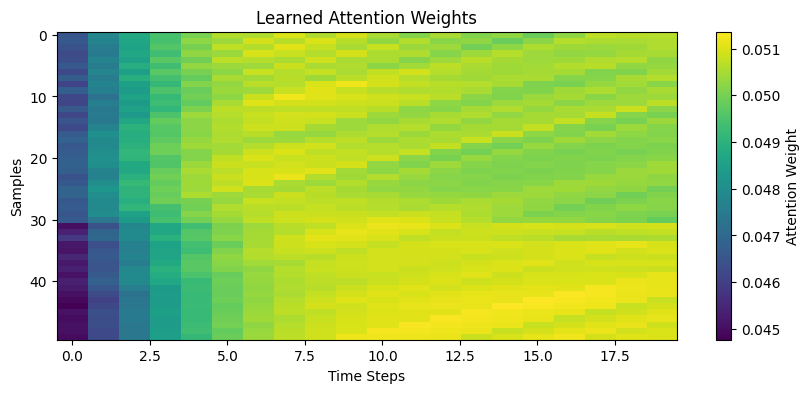

In [7]:
# Attention visualization
plt.figure(figsize=(10,4))
plt.imshow(attn_weights[:50].cpu().numpy().squeeze(), aspect="auto", cmap="viridis")
plt.colorbar(label="Attention Weight")
plt.xlabel("Time Steps")
plt.ylabel("Samples")
plt.title("Learned Attention Weights")
plt.show()
